# Autoencoders

O trabalho embaixo é baseado no paper [Autoencoder-based Network Anomaly Detection.](https://ieeexplore.ieee.org/document/8363930)

Autoencoders são um tipo de rede neural usados para codificar eficientemente um conjunto de dados, de forma não-supervisionada. Geralmente tal codificação reduz a dimensionalidade do dataset.

- Há duas funções associadas: encoding e decoding.
    - Decoding busca reverter a operação, retornando os dados ao espaço original.
- O autoencoder mantém relações não-lineares entre dados, o que não ocorre com métodos de redução de dimensionalidade como PCA

Pode-se detectar anomalias usando PCA ou Autoencoders. O processo envolve projetar os dados em um espaço de menor dimensão e, em seguida, reconstruí-los. Espera-se que os dados normais sigam o padrão aprendido durante o treinamento, resultando em um erro de reconstrução menor. As anomalias, por sua vez, apresentam um erro de reconstrução maior que um limiar ε.
- O autoencoder convolucional usa camadas convolucionais para reduzir o tempo de processamento

Framework do sistema de anomalias via autoencoder:

1. Normalização dos dados
2. Geração de dados 2D (apenas para convolucional) - usou Triangle Area Maps
3. Treinamento do autoencoder - minimizar o erro de reconstrução médio
4. Teste de autoencoder - usa o erro de reconstrução como a “pontuação de anomalia”

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


## Preparação dos Datasets
Usaremos dois datasets com o encoder: o que indiscrimina ataques diferentes (singleclass_df) e o que os separa em classes (multiclass_df).

In [191]:
# Read datasets
singleclass_df = pd.read_csv("files/5G_attack_detection_ds.csv")
multiclass_df = pd.read_csv("files_multiclass/mixed_mult_class.csv")

# Removes labels, normalizes and splits into testing/training sets
def prepare_ds(df: pd.DataFrame):
    df = df.dropna()

    labels = df.iloc[:, -1]
    features = df.iloc[:, :-1]

    # Separate non-anomalous data (label = 1) for training
    non_anomalous_data = df[df.iloc[:, -1] == 1]
    non_anomalous_labels = non_anomalous_data.iloc[:, -1]
    non_anomalous_features = non_anomalous_data.iloc[:, :-1]

    # Scale features
    scaler = StandardScaler()
    non_anomalous_features_scaled = scaler.fit_transform(non_anomalous_features)
    features_scaled = scaler.transform(features)  # Scale the entire dataset for consistency

    # Use all non-anomalous data for training
    X_train = non_anomalous_features_scaled
    y_train = non_anomalous_labels

    # Use the entire dataset (both normal and anomalous) for testing
    X_test, y_test = features_scaled, labels

    return X_train, X_test, y_train, y_test

S_X_train, S_X_test, S_y_train, S_y_test = prepare_ds(singleclass_df)
M_X_train, M_X_test, M_y_train, M_y_test = prepare_ds(multiclass_df)

# Both datasets have the same amount of columns
input_dimension = S_X_train.shape[1]

print(f'Input dimenstion equals {input_dimension}')

Input dimenstion equals 1024


## Arquitetura do Encoder

Utilizaremos a função sigmóide, como no paper.

In [192]:
input_layer = Input(shape=(input_dimension,))

# Encoder
encoding_layer_1 = Dense(64, activation='sigmoid')(input_layer)
encoding_layer_2 = Dense(32, activation='sigmoid')(encoding_layer_1)
encoding_layer_3 = Dense(16, activation='sigmoid')(encoding_layer_2)
encoding_layer_4 = Dense(8, activation='sigmoid')(encoding_layer_3)

# Decoder
decoding_layer_1 = Dense(16, activation='sigmoid')(encoding_layer_4)
decoding_layer_2 = Dense(32, activation='sigmoid')(decoding_layer_1)
decoding_layer_3 = Dense(64, activation='sigmoid')(decoding_layer_2)
output_layer = Dense(input_dimension, activation='sigmoid')(decoding_layer_3)

# Create the autoencoder model
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1024)           │        66,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,704 (537.91 KB)

 Trainable params: 137,704 (537.91 KB)

 Non-trainable params: 0 (0.00 B)

In [193]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(S_X_train, S_X_train, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

# Reconstruction error on training data
reconstructions = autoencoder.predict(S_X_train)
reconstruction_errors = np.mean(np.square(S_X_train - reconstructions), axis=1)

Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0926 - val_loss: 0.9988
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0069 - val_loss: 0.9945
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9915 - val_loss: 0.9773
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9651 - val_loss: 0.9059
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9033 - val_loss: 0.8878
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8899 - val_loss: 0.8822
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8853 - val_loss: 0.8807
Epoch 8/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8881 - val_loss: 0.8802
Epoch 9/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8809 - val_loss: 0.8799
Epoch 10/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8842 - val_loss: 0.8798
Epoch 11/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8806 - val_loss: 0.8798
Epoch 12/200
152/152 ━━━━━━━━━━━━━━━━━━━━

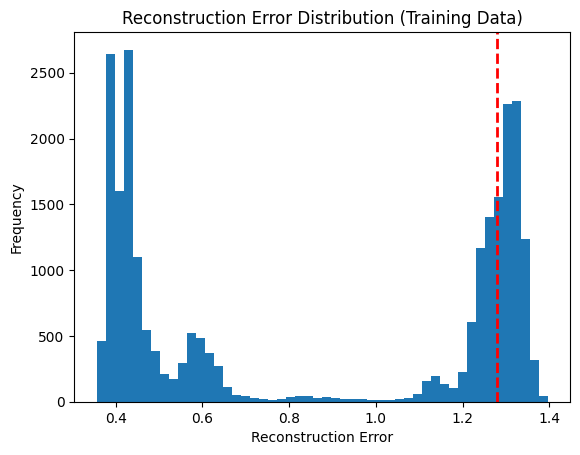

In [197]:
# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 70)

plt.hist(reconstruction_errors, bins=50)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution (Training Data)')
plt.show()

In [198]:
reconstructions_test = autoencoder.predict(S_X_test)
reconstruction_errors_test = np.mean(np.square(S_X_test - reconstructions_test), axis=1)
anomalies = reconstruction_errors_test > threshold

1511/1511 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step


In [199]:
def compare_results(anomalies_found, anomaly_label):
    anomaly_labels = anomaly_label == -1

    # Compare the arrays
    correctly_identified = (anomalies_found == anomaly_labels)

    # Calculate the number of correctly identified anomalies
    correct_count = correctly_identified.sum()

    # Calculate the total number of anomalies and normal instances
    total_anomalies = anomaly_labels.sum()
    total_normal = (~anomaly_labels).sum()

    num_anomalies_detected = anomalies_found.sum()
    print(f"Number of anomalies detected: {num_anomalies_detected}")

    # Calculate accuracy, precision, recall, etc.
    accuracy = correct_count / len(anomalies_found)

    true_positives = (anomalies_found & anomaly_labels).sum()
    false_positives = (anomalies_found & ~anomaly_labels).sum()
    false_negatives = (~anomalies_found & anomaly_labels).sum()

    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")

    if anomalies_found.sum() > 0:
        precision = true_positives / anomalies_found.sum()
    else:
        precision = 0.0  # To handle division by zero

    if total_anomalies > 0:
        recall = true_positives / total_anomalies
    else:
        recall = 0.0  # To handle division by zero

    print()

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

compare_results(anomalies, S_y_test)

Number of anomalies detected: 7252
True Positives: 0
False Positives: 7252
False Negatives: 24174

Accuracy: 0.35000413667576735
Precision: 0.0
Recall: 0.0
